<a href="https://colab.research.google.com/github/yash722/Sentimental-Analysis-Of-Tweets-Using-Decision-Trees/blob/main/FeatureExtraction_And_Predictive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from osgeo import gdal
import numpy as np
import scipy
import pandas as pd
from skimage import exposure, io
import tensorflow as tf
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import Flatten, Conv1D, Conv2D, AveragePooling2D, MaxPooling2D, AveragePooling1D, MaxPooling1D, GlobalAveragePooling1D, GlobalAveragePooling2D, Dropout, InputLayer
from keras.models import Model, Sequential, load_model
from keras import optimizers, metrics
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.initializers import glorot_uniform
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from sklearn import metrics
import tensorflow as tf
import scipy.io as sio
import numpy as np
import imageio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SPATIAL = Sequential()
SPECTRAL = Sequential()

model = ResNet50(include_top=False,
              weights='imagenet')

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model_config = model.get_config()

h, w, c = 3, 3, 12
model_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

model_updated = Model.from_config(model_config)

In [ ]:
def avg_and_copy_wts(weights, num_channels):
    average_weights = np.mean(weights, axis=-2).reshape(weights[:, :, -1:, :].shape)
    wts_copied_to_multi_channels = np.tile(average_weights, (num_channels, 1))
    return(wts_copied_to_multi_channels)

model_updated_config = model_updated.get_config()
model_updated_layer_names = [model_updated_config['layers'][x]['name'] for x in range(len(model_updated_config['layers']))]

first_conv_name = model_updated_layer_names[2]
for layer in model.layers:
    if layer.name in model_updated_layer_names:

        if layer.get_weights() != []:
            target_layer = model_updated.get_layer(layer.name)

            if layer.name in first_conv_name:
                weights = layer.get_weights()[0]
                biases  = layer.get_weights()[1]

                weights_extra_channels = np.concatenate((weights, avg_and_copy_wts(weights, c - 3)), axis=-2)

                target_layer.set_weights([weights_extra_channels, biases])
                target_layer.trainable = False
            else:
                target_layer.set_weights(layer.get_weights())
                target_layer.trainable = False

model_updated.summary()

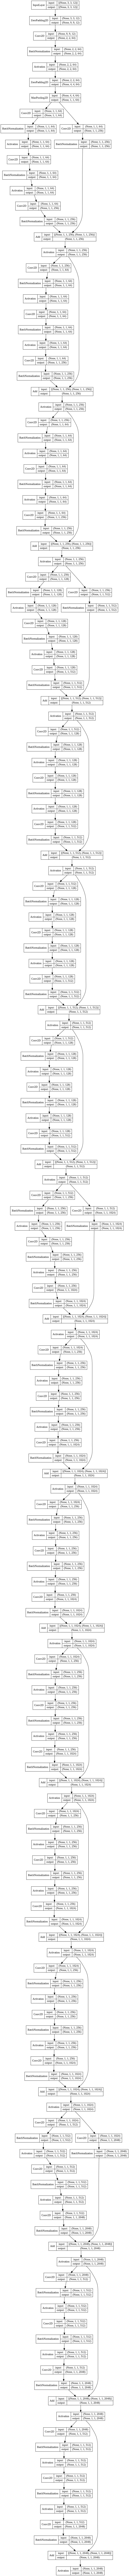

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_updated, to_file='model_plot.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
SPATIAL.add(model_updated)
SPATIAL.add(GlobalAveragePooling2D())

SPATIAL.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23615936  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 23,615,936
Trainable params: 0
Non-trainable params: 23,615,936
_________________________________________________________________


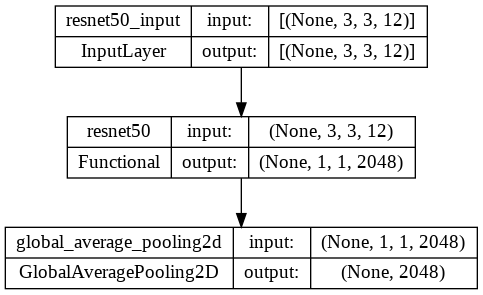

In [ ]:
plot_model(SPATIAL, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_config = model.get_config()

h, w, c = 1, 12, 1
model_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

models_updated = Model.from_config(model_config)

In [ ]:
from keras.layers.pooling import GlobalAveragePooling2D
def avg_wts(weights):
  average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
  return(average_weights)

models_updated_config = models_updated.get_config()
models_updated_layer_names = [models_updated_config['layers'][x]['name'] for x in range(len(models_updated_config['layers']))]

first_conv_name = models_updated_layer_names[2]
for layer in model.layers:
    if layer.name in models_updated_layer_names:

      if layer.get_weights() != []:
        target_layer = models_updated.get_layer(layer.name)

        if layer.name in first_conv_name:
          weights = layer.get_weights()[0]
          biases  = layer.get_weights()[1]

          weights_single_channel = avg_wts(weights)

          target_layer.set_weights([weights_single_channel, biases])
          target_layer.trainable = False

        else:
          target_layer.set_weights(layer.get_weights())
          target_layer.trainable = False

models_updated.summary()


In [ ]:
SPECTRAL.add(models_updated)
SPECTRAL.add(GlobalAveragePooling2D())

SPECTRAL.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23581440  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 23,581,440
Trainable params: 0
Non-trainable params: 23,581,440
_________________________________________________________________


In [ ]:
image = "drive/MyDrive/Farmland/water_urban (1).tif"
driverTif = gdal.GetDriverByName("GTiff")
image_dataset = gdal.Open(image)

In [ ]:
n_bands = image_dataset.RasterCount
band_data = []
# Rows, Columns, Bands
image_dataset.RasterYSize, image_dataset.RasterXSize, image_dataset.RasterCount

(95, 217, 12)

In [ ]:
for i in range(1, n_bands+1):
  band = image_dataset.GetRasterBand(i).ReadAsArray()
  band_data.append(band)
band_data = np.dstack(band_data)

In [ ]:
bare_short_img = band_data

In [ ]:
band_data

array([[[1039.75 ,  851.75 ,  992.875, ..., 1915.75 , 1859.75 ,
         1624.25 ],
        [1039.75 ,  851.75 ,  992.875, ..., 1915.75 , 1859.75 ,
         1624.25 ],
        [1039.75 ,  901.375, 1029.5  , ..., 1915.75 , 1859.75 ,
         1624.25 ],
        ...,
        [ 968.625, 1149.125, 1349.75 , ..., 1529.375, 2081.625,
         1838.5  ],
        [ 968.625, 1149.125, 1349.75 , ..., 1529.375, 2081.625,
         1838.5  ],
        [ 968.625, 1110.25 , 1307.75 , ..., 1529.375, 2000.5  ,
         1785.125]],

       [[1039.75 ,  851.75 ,  992.875, ..., 1915.75 , 1859.75 ,
         1624.25 ],
        [1039.75 ,  851.75 ,  992.875, ..., 1915.75 , 1859.75 ,
         1624.25 ],
        [1039.75 ,  901.375, 1029.5  , ..., 1915.75 , 1859.75 ,
         1624.25 ],
        ...,
        [ 968.625, 1149.125, 1349.75 , ..., 1529.375, 2081.625,
         1838.5  ],
        [ 968.625, 1149.125, 1349.75 , ..., 1529.375, 2081.625,
         1838.5  ],
        [ 968.625, 1110.25 , 1307.75 , ..., 1529

Text(0.5, 0.92, 'simple 3D scatter plot')

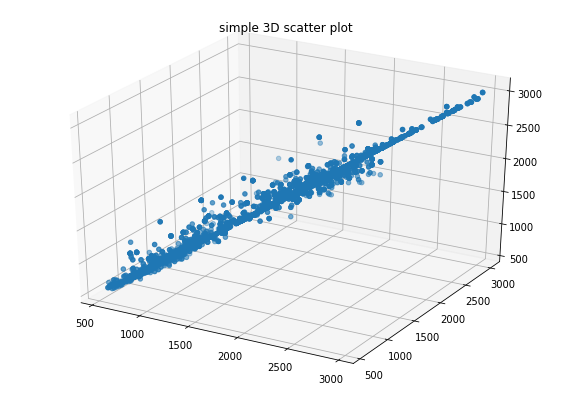

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(bare_short_img[:, 3], bare_short_img[:, 2], bare_short_img[:, 1])
plt.title("simple 3D scatter plot")

In [ ]:
bare_short_img[0, 1]

array([ 722.375,  806.5  ,  958.375, 1021.5  , 1336.75 , 1584.75 ,
       1690.125, 1730.   , 1847.   , 1659.375, 2260.25 , 1971.5  ])

In [ ]:
spectral_dataset = np.array(0)

In [ ]:
for i in range(215):
  for j in range(94):
    pix_value = band_data[i, j]
    pix_value = pix_value.reshape(1, 12, 1)
    pix_value = np.expand_dims(pix_value, axis=0)
    pred = SPECTRAL.predict(pix_value)
    print(f"Done with pixel - {i+1, j+1}")
    spectral_dataset = np.append(spectral_dataset, pred)

In [ ]:
spectral_dataset = spectral_dataset[1:]

In [ ]:
spectral_dataset = spectral_dataset.reshape(20210, 2048)

In [ ]:
spectral_dataset = spectral_dataset[:20000, :]

In [ ]:
spectral_dataset.shape

(20000, 2048)

In [ ]:
image2 = "drive/MyDrive/Farmland/Urban_Tall.tif"
driverTif = gdal.GetDriverByName("GTiff")
image2_dataset = gdal.Open(image2)
n_bands = image2_dataset.RasterCount
urban_tall = []
for i in range(1, n_bands+1):
  band = image2_dataset.GetRasterBand(i).ReadAsArray()
  urban_tall.append(band)
urban_tall = np.dstack(urban_tall)

In [ ]:
image2 = "drive/MyDrive/Farmland/Bare.tif"
driverTif = gdal.GetDriverByName("GTiff")
image2_dataset = gdal.Open(image2)
n_bands = image2_dataset.RasterCount
bare = []
for i in range(1, n_bands+1):
  band = image2_dataset.GetRasterBand(i).ReadAsArray()
  bare.append(band)
bare = np.dstack(bare)

In [ ]:
image2 = "drive/MyDrive/Farmland/Short.tif"
driverTif = gdal.GetDriverByName("GTiff")
image2_dataset = gdal.Open(image2)
n_bands = image2_dataset.RasterCount
short = []
for i in range(1, n_bands+1):
  band = image2_dataset.GetRasterBand(i).ReadAsArray()
  short.append(band)
short = np.dstack(short)

In [ ]:
image2 = "drive/MyDrive/Farmland/Urban.tif"
driverTif = gdal.GetDriverByName("GTiff")
image2_dataset = gdal.Open(image2)
n_bands = image2_dataset.RasterCount
urban = []
for i in range(1, n_bands+1):
  band = image2_dataset.GetRasterBand(i).ReadAsArray()
  urban.append(band)
urban = np.dstack(urban)

In [ ]:
image2 = "drive/MyDrive/Farmland/Water.tif"
driverTif = gdal.GetDriverByName("GTiff")
image2_dataset = gdal.Open(image2)
n_bands = image2_dataset.RasterCount
water = []
for i in range(1, n_bands+1):
  band = image2_dataset.GetRasterBand(i).ReadAsArray()
  water.append(band)
water = np.dstack(water)

In [ ]:
image2 = "drive/MyDrive/Farmland/Tall.tif"
driverTif = gdal.GetDriverByName("GTiff")
image2_dataset = gdal.Open(image2)
n_bands = image2_dataset.RasterCount
tall = []
for i in range(1, n_bands+1):
  band = image2_dataset.GetRasterBand(i).ReadAsArray()
  tall.append(band)
tall = np.dstack(tall)

In [ ]:
band_data = []

In [ ]:
band_data = np.append(bare, short)

In [ ]:
band_data = band_data.reshape(2737422, 12)

In [ ]:
band_data = np.append(band_data, tall)
band_data = np.append(band_data, urban)
band_data =  np.append(band_data, water)

In [ ]:
band_data = band_data.reshape(4163358, 12)

In [ ]:
band_data.shape

(4163358, 12)

In [ ]:
# bare = bare[:100, :100, :]
# short = short[:100, :100, :]
urban = urban[:200, :200, :]
water = water[:200, :200, :]
tall = tall[:200, :200, :]

In [ ]:
bare = np.append(bare, short)
bare = np.append(bare, urban)
bare = np.append(bare, water)
bare = np.append(bare, tall)

In [ ]:
bare = bare.reshape(50000, 12)

In [ ]:
NDVI = np.array([(j[7] - j[3])/(j[7] + j[3]) for j in band_data])
EVI = np.array([(2.5*(j[7] - j[3]))/((j[7] + (2.4)*j[3]) + 10000) for j in band_data])

In [ ]:
band_data.shape

(553, 471, 12)

In [ ]:
band_data = band_data[:200, :100, :]

In [ ]:
bare_short_img = bare_short_img.reshape(260463, 12)

In [ ]:
urban_tall.shape

(431728, 12)

In [ ]:
urban_tall = urban_tall[:400, :50, :]

In [ ]:
urban_tall = urban_tall.reshape(431728, 12)

In [ ]:
band_data = np.append(band_data, urban_tall)

In [ ]:
band_data = band_data

In [ ]:
band_data = band_data.reshape(217, 95, 12)

In [ ]:
for i in range(215):
  for j in range(94):
    pix_value = band_data[i, j]
    pix_value = pix_value.reshape(1, 12, 1)
    pix_value = np.expand_dims(pix_value, axis=0)
    pred = SPECTRAL.predict(pix_value)
    print(f"Done with pixel - {i+1, j+1}")
    spectral_dataset = np.append(spectral_dataset, pred)

In [ ]:
spectral_dataset.shape

(81920000,)

In [ ]:
image3 = "drive/MyDrive/Farmland/water_rest_clpd2.tif"
driverTif = gdal.GetDriverByName("GTiff")
image3_dataset = gdal.Open(image3)
n_bands = image3_dataset.RasterCount
water_rest = []
for i in range(1, n_bands+1):
  band = image3_dataset.GetRasterBand(i).ReadAsArray()
  water_rest.append(band)
water_rest = np.dstack(water_rest)

In [ ]:
water_rest.shape

(232, 517, 12)

In [ ]:
band_data = np.append(band_data, water)

In [ ]:
band_data.shape

(8935284,)

In [ ]:
band_data = band_data.reshape(744607, 12)

In [ ]:
for i in range(200):
  for j in range(300):
    pix_value = water[i, j]
    pix_value = pix_value.reshape(1, 12, 1)
    pix_value = np.expand_dims(pix_value, axis=0)
    pred = SPECTRAL.predict(pix_value)
    print(f"Done with pixel - {i+1, j+1}")
    spectral_dataset = np.append(spectral_dataset, pred)

In [ ]:
spectral_dataset = spectral_dataset.reshape(50000, 2048)

In [ ]:
spectral_dataset

In [ ]:
np.unique(spectral_dataset).shape

(1365243,)

In [ ]:
np.savetxt('drive/MyDrive/Farmland/spectral_dataset.txt', spectral_dataset, fmt='%1.30f')

In [ ]:
spectral_ = np.loadtxt('drive/MyDrive/Farmland/spectral_dataset_new.txt', dtype = np.float32)

In [ ]:
spectral_.shape

(50000, 2048)

In [ ]:
spectral_[30000:, :] = spectral_dataset

In [ ]:
spectral_dataset = spectral_dataset[:30000, :]

In [ ]:
water_rest.shape

(232, 517, 12)

In [ ]:
for i in range(50):
  for j in range(400):
    pix_value = water_rest[i, j]
    pix_value = pix_value.reshape(1, 12, 1)
    pix_value = np.expand_dims(pix_value, axis=0)
    pred = SPECTRAL.predict(pix_value)
    print(f"Done with pixel - {i+1, j+1}")
    spectral_dataset = np.append(spectral_dataset, pred)

In [ ]:
spectral_.shape

(50000, 2048)

In [ ]:
np.savetxt('drive/MyDrive/Farmland/spectral_dataset_new.txt', spectral_, fmt='%1.30f')

SPATIAL DATASET

In [ ]:
spatial_dataset = np.array(0)

In [ ]:
for i in range(215):
  for j in range(93):
    pix_value = band_data[i:i+3, j:j+3, :]
    pix_value = np.expand_dims(pix_value, axis=0)
    pred = SPATIAL.predict(pix_value)
    print(f"Done with pixel - {i+1, j+1}")
    spatial_dataset = np.append(spatial_dataset, pred)

In [ ]:
spatial_dataset = spatial_dataset[1:]

In [ ]:
spatial_dataset = np.append(spatial_dataset, [0,0,0,0,0])

In [ ]:
spatial_dataset = spatial_dataset[:40949760]

In [ ]:
spatial_dataset.shape

(40949760,)

In [ ]:
spatial_dataset = spatial_dataset.reshape(19995, 2048)

In [ ]:
spectral_.shape

(50000, 2048)

In [ ]:
spectral_ = spectral_[:49995, :]

In [ ]:
for i in range(200):
  for j in range(100):
    pix_value = urban_tall[i:i+3, j:j+3, :]
    pix_value = np.expand_dims(pix_value, axis=0)
    pred = SPATIAL.predict(pix_value)
    print(f"Done with pixel - {i+1, j+1}")
    spatial_dataset = np.append(spatial_dataset, pred)

In [ ]:
spatial_dataset.shape

(81920000,)

In [ ]:
for i in range(100):
  for j in range(100):
    pix_value = water[i:i+3, j:j+3, :]
    pix_value = np.expand_dims(pix_value, axis=0)
    pred = SPATIAL.predict(pix_value)
    print(f"Done with pixel - {i+1, j+1}")
    spatial_dataset = np.append(spatial_dataset, pred)

In [ ]:
spatial_dataset.shape

(102400000,)

In [ ]:
spatial_dataset = spatial_dataset.reshape(50000, 2048)

In [ ]:
np.unique(spatial_dataset).shape

(24147995,)

In [ ]:
np.savetxt('drive/MyDrive/Farmland/spatial_dataset.txt', spatial_dataset, fmt='%1.30f')

In [ ]:
spatial_ = np.loadtxt("drive/MyDrive/Farmland/spatial_dataset.txt", dtype = np.float32)

In [ ]:
spatial_dataset.shape

(19995, 2048)

In [ ]:
spatial_.shape

(50000, 2048)

In [ ]:
spatial_[30000:49995, :] = spatial_dataset

In [ ]:
spatial_dataset = spatial_dataset[:30000, :]

In [ ]:
spatial_dataset.shape

(30000, 2048)

In [ ]:
for i in range(50):
  for j in range(400):
    pix_value = water_rest[i:i+3, j:j+3, :]
    pix_value = np.expand_dims(pix_value, axis=0)
    pred = SPATIAL.predict(pix_value)
    print(f"Done with pixel - {i+1, j+1}")
    spatial_dataset = np.append(spatial_dataset, pred)

In [ ]:
spatial_dataset.shape

(102400000,)

In [ ]:
spatial_dataset = spatial_dataset.reshape(50000,2048)

In [ ]:
np.savetxt('drive/MyDrive/Farmland/spatial_dataset_new.txt', spatial_, fmt='%1.30f')

LABELS

In [ ]:
bare_vegetation_mask = io.imread("drive/MyDrive/Farmland/label.png")
np.unique(bare_vegetation_mask)

array([  0,   5,  15,  16,  20,  21,  22,  25,  27,  28,  30,  32,  42,
        45,  46,  47,  48,  52,  53,  54,  56,  57,  59,  61,  63,  64,
        79,  80,  87,  93,  95,  96,  99, 102, 104, 106, 109, 111, 112,
       116, 121, 123, 124, 125, 127, 128, 133, 135, 137, 138, 139, 143,
       144, 146, 148, 151, 152, 153, 159, 160, 163, 164, 167, 168, 170,
       171, 172, 173, 174, 175, 176, 178, 179, 181, 182, 183, 184, 188,
       189, 191, 192, 195, 200, 207, 208, 212, 213, 216, 217, 219, 220,
       223, 224, 226, 227, 231, 232, 237, 239, 240, 243, 244, 246, 247,
       248, 249, 252, 255], dtype=uint8)

[1 2]


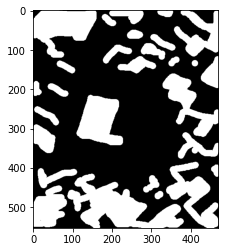

In [ ]:
bare_vegetation_mask = np.where(bare_vegetation_mask>0, 2, 1)
print(np.unique(bare_vegetation_mask))
plt.imshow(bare_vegetation_mask, cmap='gray')

In [ ]:
bare_vegetation_mask.shape

(553, 471)

[3 4]


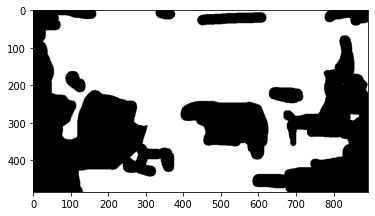

In [ ]:
urban_tall_mask = io.imread("drive/MyDrive/Farmland/Urban_Tall_Mask.png")
urban_tall_mask = np.where(urban_tall_mask>0, 3, 4)
print(np.unique(urban_tall_mask))
plt.imshow(urban_tall_mask, cmap='gray')

In [ ]:
urban_tall_mask.shape

(484, 892)

In [ ]:
water_mask = io.imread("drive/MyDrive/Farmland/Water_Mask.png")
np.unique(water_mask)

array([255], dtype=uint8)

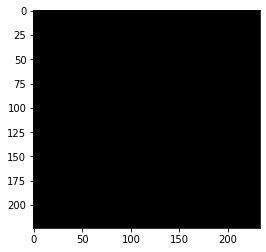

In [ ]:
plt.imshow(water_mask, cmap = "gray")

[5]


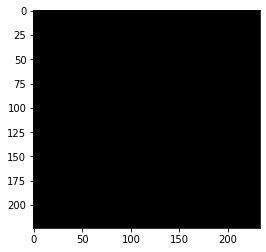

In [ ]:
water_mask = np.where(water_mask>0, 5, 10)
print(np.unique(water_mask))
plt.imshow(water_mask, cmap='gray')

In [ ]:
for i in range(224):
  water_mask = np.append(water_mask, np.dstack([5]))

In [ ]:
water_mask.shape

(52416,)

In [ ]:
bare_vegetation_mask = bare_vegetation_mask.reshape(260463)

In [ ]:
urban_tall_mask = urban_tall_mask.reshape(431728)

In [ ]:
bare_vegetation_mask = np.append(bare_vegetation_mask, urban_tall_mask)
bare_vegetation_mask = np.append(bare_vegetation_mask, water_mask)

In [ ]:
bare_vegetation_mask.shape

(744607,)

In [ ]:
np.savetxt("drive/MyDrive/Farmland/bare_short_mask.txt", bare_vegetation_mask[:200, :100], fmt="%1.0f")
np.savetxt("drive/MyDrive/Farmland/urban_tall_mask.txt", urban_tall_mask[:200, :100], fmt="%1.0f")
np.savetxt("drive/MyDrive/Farmland/water_mask.txt", water_mask[:100, :100], fmt="%1.0f")

In [ ]:
bare_short_mask = np.loadtxt("drive/MyDrive/Farmland/bare_short_mask.txt", dtype=np.float32)
urban_tall_mask = np.loadtxt("drive/MyDrive/Farmland/urban_tall_mask.txt", dtype=np.float32)
water_mask = np.loadtxt("drive/MyDrive/Farmland/water_mask.txt", dtype=np.float32)

In [ ]:
np.unique(bare_short_mask), np.unique(urban_tall_mask), np.unique(water_mask)

(array([1., 2.], dtype=float32),
 array([3., 4.], dtype=float32),
 array([5.], dtype=float32))

In [ ]:
spectral_feature = np.loadtxt('drive/MyDrive/Farmland/spectral_dataset_new.txt', dtype=np.float32)
spatial_feature = np.loadtxt('drive/MyDrive/Farmland/spatial_dataset_new.txt', dtype=np.float32)

In [ ]:
fused_feature = np.multiply(spectral_, spatial_)

In [ ]:
fused_feature.shape

(50000, 2048)

In [ ]:
np.savetxt('drive/MyDrive/Farmland/fused_feature_dataset_new.txt', fused_feature, fmt='%1.30f')

In [ ]:
fused_feature = np.loadtxt('drive/MyDrive/Farmland/fused_feature_dataset_new.txt', dtype=np.float32)

In [ ]:
fused_feature.shape

(50000, 2048)

In [ ]:
water_urban_mask = io.imread("drive/MyDrive/Farmland/water_urban_mask.png")

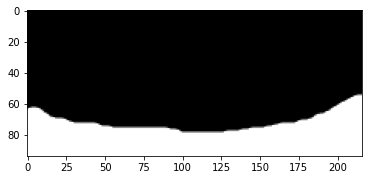

In [ ]:
plt.imshow(water_urban_mask, cmap="gray")

[4 5]


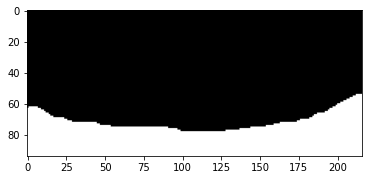

In [ ]:
water_urban_mask = np.where(water_urban_mask>0, 5, 4)
print(np.unique(water_urban_mask))
plt.imshow(water_urban_mask, cmap='gray')

In [ ]:
water_urban_mask.shape

(94, 216)

In [ ]:
water_urban_mask = water_urban_mask.reshape(20304)

In [ ]:
label_mask = np.array(0)

In [ ]:
label_mask = np.append(label_mask, bare_short_mask)

In [ ]:
label_mask = label_mask[1:]

In [ ]:
label_mask = np.append(label_mask, urban_tall_mask)

In [ ]:
label_mask.shape

(40000,)

In [ ]:
label_mask[30000:49995] = water_urban_mask[:19995]

In [ ]:
label_mask = np.append(label_mask, water_rest_clpd_mask[10000:20000])

In [ ]:
label_mask.shape

(50000,)

In [ ]:
np.savetxt('drive/MyDrive/Farmland/label_mask_dataset_new.txt', label_mask, fmt='%1.0f')

LABEL MASK

In [ ]:
label_mask = np.loadtxt("drive/MyDrive/Farmland/label_mask_dataset.txt", dtype = np.float32)

In [ ]:
df = pd.DataFrame(band_data)

In [ ]:
band_data.shape

(744607, 12)

In [ ]:
bands_1 = np.array([df.iloc[i, :] for i in range(744607) if bare_vegetation_mask[i] == 1])
bands_2 = np.array([df.iloc[i, :] for i in range(744607) if bare_vegetation_mask[i] == 2])
bands_3 = np.array([df.iloc[i, :] for i in range(744607) if bare_vegetation_mask[i] == 3])
bands_4 = np.array([df.iloc[i, :] for i in range(744607) if bare_vegetation_mask[i] == 4])
bands_5 = np.array([df.iloc[i, :] for i in range(744607) if bare_vegetation_mask[i] == 5])

In [ ]:
len(bands_1), len(bands_2), len(bands_3), len(bands_4), len(bands_5)

(163402, 97061, 170395, 261333, 52416)

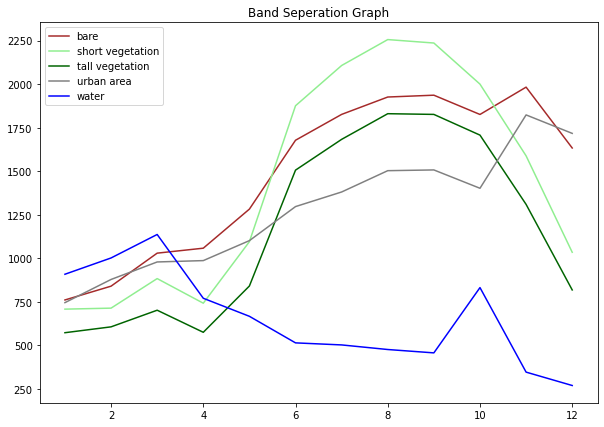

In [ ]:
fig = plt.figure(figsize = (10, 7))
x = [1,2,3,4,5,6,7,8,9,10,11,12]
y1 = [np.mean(bands_1[:, i]) for i in range(12)]
y2 = [np.mean(bands_2[:, i]) for i in range(12)]
y3 = [np.mean(bands_3[:, i]) for i in range(12)]
y4 = [np.mean(bands_4[:, i]) for i in range(12)]
y5 = [np.mean(bands_5[:, i]) for i in range(12)]
plt.plot(x,y1, linestyle="-", color="brown")
plt.plot(x,y2, linestyle="-", color="lightgreen")
plt.plot(x,y3, linestyle="-", color="darkgreen")
plt.plot(x,y4, linestyle="-", color="grey")
plt.plot(x,y5, linestyle="-", color="blue")
plt.title("Band Seperation Graph")
plt.legend(["bare", "short vegetation", "tall vegetation", "urban area", "water"])

Text(0, 0.5, 'EVI')

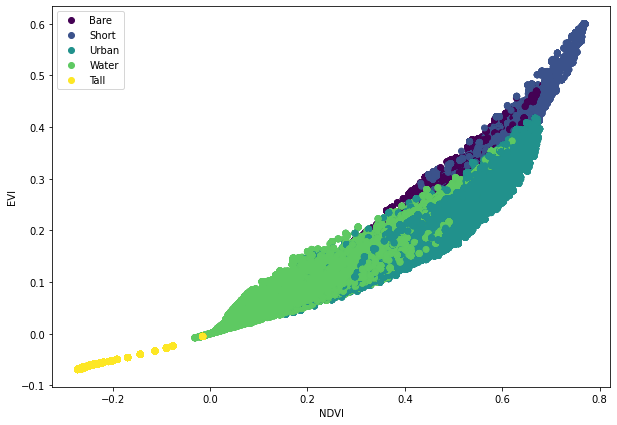

In [ ]:
fig = plt.figure(figsize = (10, 7))
scatter = plt.scatter(NDVI, EVI, c=bare_vegetation_mask)
plt.legend(handles=scatter.legend_elements()[0], labels=["Bare", "Short", "Urban", "Water", "Tall"])
plt.xlabel("NDVI")
plt.ylabel("EVI")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(spectral_, label_mask, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 2048), (10000, 2048), (40000,), (10000,))

In [ ]:
X_train

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 30.390306,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [ ]:
y_train

array([5., 5., 5., ..., 5., 2., 2.], dtype=float32)

In [ ]:
np.unique(X_test).shape

(1837965,)

In [ ]:
np.unique(y_test).shape

(5,)

In [ ]:
y_test

array([5., 1., 1., ..., 2., 1., 2.], dtype=float32)

In [ ]:
def calculate_tpr_fpr(y_real, y_pred):
    cm = metrics.confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

In [ ]:
def get_all_roc_coordinates(y_real, y_proba):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RF_model = RandomForestClassifier(n_estimators=520)

In [ ]:
RF_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=520)

In [ ]:
prediction_RF = RF_model.predict(X_test)
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

Accuracy =  0.8773


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


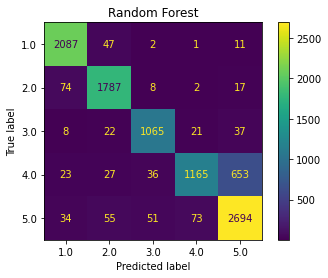

In [ ]:
metrics.plot_confusion_matrix(RF_model, X_test, y_test)
plt.title("Random Forest")
plt.show()

In [ ]:
classes = RF_model.classes_
classes

array([1., 2., 3., 4., 5.], dtype=float32)

In [ ]:
y_proba = RF_model.predict_proba(X_test)

In [ ]:
y_test_act = np.array(-1)
for i in y_test:
  if i == 1:
    y_test_act = np.append(y_test_act, [1,0,0,0,0])
  elif i == 2:
    y_test_act = np.append(y_test_act, [0,1,0,0,0])
  elif i == 3:
    y_test_act = np.append(y_test_act, [0,0,1,0,0])
  elif i == 4:
    y_test_act= np.append(y_test_act, [0,0,0,1,0])
  elif i == 5:
    y_test_act= np.append(y_test_act, [0,0,0,0,1])
y_test_act = y_test_act[1:]

In [ ]:
y_test_act = y_test_act.reshape(10000, 5)

In [ ]:
prediction_rf = np.array(-1)
for i in prediction_RF:
  if i == 1:
    prediction_rf = np.append(prediction_rf, [1,0,0,0,0])
  elif i == 2:
    prediction_rf = np.append(prediction_rf, [0,1,0,0,0])
  elif i == 3:
    prediction_rf = np.append(prediction_rf, [0,0,1,0,0])
  elif i == 4:
    prediction_rf= np.append(prediction_rf, [0,0,0,1,0])
  elif i == 5:
    prediction_rf= np.append(prediction_rf, [0,0,0,0,1])
prediction_rf = prediction_rf[1:]

In [ ]:
prediction_rf = prediction_rf.reshape(10000, 5)

In [ ]:
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(5):
    fpr_rf[i], tpr_rf[i], _ = metrics.roc_curve(y_test_act[:, i], prediction_rf[:, i])
    roc_auc_rf[i] = metrics.auc(fpr_rf[i], tpr_rf[i])

# Compute micro-average ROC curve and ROC area
fpr_rf["micro"], tpr_rf["micro"], _ = metrics.roc_curve(y_test_act.ravel(), prediction_rf.ravel())
roc_auc_rf["micro"] = metrics.auc(fpr_rf["micro"], tpr_rf["micro"])

In [ ]:
fpr_rf, tpr_rf

({0: array([0.       , 0.0177025, 1.       ]),
  1: array([0.       , 0.0186144, 1.       ]),
  2: array([0.        , 0.01096417, 1.        ]),
  3: array([0.        , 0.01198123, 1.        ]),
  4: array([0.        , 0.10122656, 1.        ]),
  'micro': array([0.     , 0.03005, 1.     ])},
 {0: array([0.        , 0.97160149, 1.        ]),
  1: array([0.        , 0.94650424, 1.        ]),
  2: array([0.        , 0.92367736, 1.        ]),
  3: array([0.        , 0.61186975, 1.        ]),
  4: array([0.        , 0.92672859, 1.        ]),
  'micro': array([0.    , 0.8798, 1.    ])})

In [ ]:
XGB_model = xgb.XGBClassifier()

In [ ]:
XGB_model.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
prediction_XGB = XGB_model.predict(X_test)
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_XGB))

Accuracy =  0.8662


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


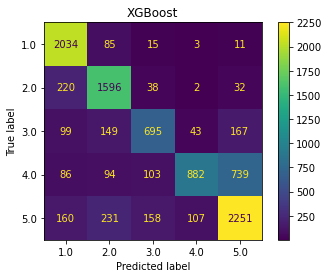

In [ ]:
metrics.plot_confusion_matrix(XGB_model, X_test, y_test)
plt.title("XGBoost")
plt.show()

In [ ]:
prediction_xgb = np.array(-1)
for i in prediction_XGB:
  if i == 1:
    prediction_xgb = np.append(prediction_xgb, [1,0,0,0,0])
  elif i == 2:
    prediction_xgb = np.append(prediction_xgb, [0,1,0,0,0])
  elif i == 3:
    prediction_xgb = np.append(prediction_xgb, [0,0,1,0,0])
  elif i == 4:
    prediction_xgb= np.append(prediction_xgb, [0,0,0,1,0])
  elif i == 5:
    prediction_xgb= np.append(prediction_xgb, [0,0,0,0,1])
prediction_xgb = prediction_xgb[1:]
prediction_xgb = prediction_xgb.reshape(10000, 5)

In [ ]:
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()
for i in range(5):
    fpr_xgb[i], tpr_xgb[i], _ = metrics.roc_curve(y_test_act[:, i], prediction_xgb[:, i])
    roc_auc_xgb[i] = metrics.auc(fpr_xgb[i], tpr_xgb[i])

# Compute micro-average ROC curve and ROC area
fpr_xgb["micro"], tpr_xgb["micro"], _ = metrics.roc_curve(y_test_act.ravel(), prediction_xgb.ravel())
roc_auc_xgb["micro"] = metrics.auc(fpr_xgb["micro"], tpr_xgb["micro"])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors=5)

In [ ]:
KNN_model.fit(X_train,y_train)

KNeighborsClassifier()

In [ ]:
prediction_KNN = KNN_model.predict(X_test)
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_KNN))

Accuracy =  0.8658


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


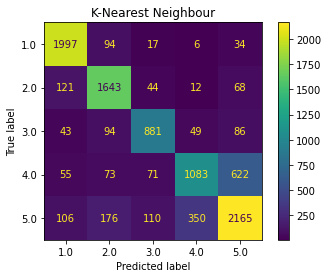

In [ ]:
metrics.plot_confusion_matrix(KNN_model, X_test, y_test)
plt.title("K-Nearest Neighbour")
plt.show()

In [ ]:
prediction_knn = np.array(-1)
for i in prediction_KNN:
  if i == 1:
    prediction_knn = np.append(prediction_knn, [1,0,0,0,0])
  elif i == 2:
    prediction_knn = np.append(prediction_knn, [0,1,0,0,0])
  elif i == 3:
    prediction_knn = np.append(prediction_knn, [0,0,1,0,0])
  elif i == 4:
    prediction_knn= np.append(prediction_knn, [0,0,0,1,0])
  elif i == 5:
    prediction_knn= np.append(prediction_knn, [0,0,0,0,1])
prediction_knn = prediction_knn[1:]
prediction_knn = prediction_knn.reshape(10000, 5)

In [ ]:
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(5):
    fpr_knn[i], tpr_knn[i], _ = metrics.roc_curve(y_test_act[:, i], prediction_knn[:, i])
    roc_auc_knn[i] = metrics.auc(fpr_knn[i], tpr_knn[i])

# Compute micro-average ROC curve and ROC area
fpr_knn["micro"], tpr_knn["micro"], _ = metrics.roc_curve(y_test_act.ravel(), prediction_knn.ravel())
roc_auc_knn["micro"] = metrics.auc(fpr_knn["micro"], tpr_knn["micro"])

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
prediction_SVC = clf.predict(X_test)
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_SVC))

Accuracy =  0.8783


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


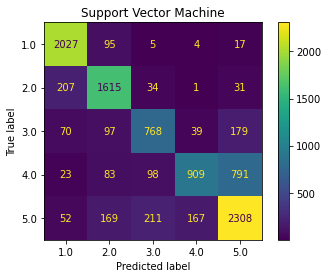

In [ ]:
metrics.plot_confusion_matrix(clf, X_test, y_test)
plt.title("Support Vector Machine")
plt.show()

In [ ]:
prediction_svm = np.array(-1)
for i in prediction_SVC:
  if i == 1:
    prediction_svm = np.append(prediction_svm, [1,0,0,0,0])
  elif i == 2:
    prediction_svm = np.append(prediction_svm, [0,1,0,0,0])
  elif i == 3:
    prediction_svm = np.append(prediction_svm, [0,0,1,0,0])
  elif i == 4:
    prediction_svm= np.append(prediction_svm, [0,0,0,1,0])
  elif i == 5:
    prediction_svm= np.append(prediction_svm, [0,0,0,0,1])
prediction_svm = prediction_svm[1:]
prediction_svm = prediction_svm.reshape(10000, 5)

In [ ]:
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()
for i in range(5):
    fpr_svm[i], tpr_svm[i], _ = metrics.roc_curve(y_test_act[:, i], prediction_svm[:, i])
    roc_auc_svm[i] = metrics.auc(fpr_svm[i], tpr_svm[i])

# Compute micro-average ROC curve and ROC area
fpr_svm["micro"], tpr_svm["micro"], _ = metrics.roc_curve(y_test_act.ravel(), prediction_svm.ravel())
roc_auc_svm["micro"] = metrics.auc(fpr_svm["micro"], tpr_svm["micro"])

In [ ]:
y_train_ann = np.array(-1)
for i in y_train:
  if i == 1:
    y_train_ann = np.append(y_train_ann, [1,0,0,0,0])
  elif i == 2:
    y_train_ann = np.append(y_train_ann, [0,1,0,0,0])
  elif i == 3:
    y_train_ann = np.append(y_train_ann, [0,0,1,0,0])
  elif i == 4:
    y_train_ann = np.append(y_train_ann, [0,0,0,1,0])
  elif i == 5:
    y_train_ann = np.append(y_train_ann, [0,0,0,0,1])

In [ ]:
y_train_ann = y_train_ann[1:].reshape(40000, 5)

In [ ]:
y_train

array([4., 4., 4., ..., 4., 2., 2.], dtype=float32)

In [ ]:
y_train_ann

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [ ]:
model_ANN = Sequential()
model_ANN.add(InputLayer(input_shape=(2048)))
model_ANN.add(Dropout(0.2))
model_ANN.add(Dense(128, activation='relu'))
model_ANN.add(Dense(64, activation='relu'))
model_ANN.add(Dropout(0.2))
model_ANN.add(Dense(32, activation='relu'))
model_ANN.add(Dense(5, activation="softmax"))
model_ANN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                                 
Total params: 272,773
Trainable params: 272,773
Non-tr

In [ ]:
model_ANN.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model_ANN.fit(X_train, y_train_ann, epochs=20)

Epoch 1/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6084 - accuracy: 0.7472
Epoch 2/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4816 - accuracy: 0.8001
Epoch 3/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4478 - accuracy: 0.8120
Epoch 4/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4311 - accuracy: 0.8184
Epoch 5/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4166 - accuracy: 0.8238
Epoch 6/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4101 - accuracy: 0.8271
Epoch 7/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3997 - accuracy: 0.8325
Epoch 8/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3961 - accuracy: 0.8342
Epoch 9/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3883 - accuracy: 0.8350
Epoch 10/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.384

In [ ]:
prediction_ANN = model_ANN.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [ ]:
loss, accuracy =  model_ANN.evaluate(X_test, y_test_act, verbose=2)
print("Accuracy   : {:5.2f}".format(accuracy))

313/313 - 1s - loss: 0.3179 - accuracy: 0.8592 - 667ms/epoch - 2ms/step
Accuracy   :  0.86


In [ ]:
prediction_ANN

array([[0.21715203, 0.178411  , 0.11409009, 0.18936901, 0.3009779 ],
       [0.21715203, 0.178411  , 0.11409009, 0.18936901, 0.3009779 ],
       [0.21715203, 0.178411  , 0.11409009, 0.18936901, 0.3009779 ],
       ...,
       [0.21715203, 0.178411  , 0.11409009, 0.18936901, 0.3009779 ],
       [0.21715203, 0.178411  , 0.11409009, 0.18936901, 0.3009779 ],
       [0.21715203, 0.178411  , 0.11409009, 0.18936901, 0.3009779 ]],
      dtype=float32)

In [ ]:
prediction_ann = np.array(-1)
for i in prediction_ANN:
  val = np.where(i == i.max(), 1, 0).tolist()
  prediction_ann = np.append(prediction_ann, val)

prediction_ann = prediction_ann[1:].reshape(10000, 5)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_ann = dict()
tpr_ann = dict()
roc_auc_ann = dict()
for i in range(5):
    fpr_ann[i], tpr_ann[i], _ = metrics.roc_curve(y_test_act[:, i], prediction_ann[:, i])
    roc_auc_ann[i] = metrics.auc(fpr_ann[i], tpr_ann[i])

# Compute micro-average ROC curve and ROC area
fpr_ann["micro"], tpr_ann["micro"], _ = metrics.roc_curve(y_test_act.ravel(), prediction_ann.ravel())
roc_auc_ann["micro"] = metrics.auc(fpr_ann["micro"], tpr_ann["micro"])

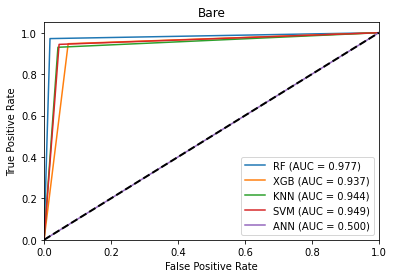

In [ ]:
plt.plot(fpr_rf[0], tpr_rf[0], label='RF (AUC = {:.3f})'.format(roc_auc_rf[0]))
plt.plot(fpr_xgb[0], tpr_xgb[0], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[0]))
plt.plot(fpr_knn[0], tpr_knn[0], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[0]))
plt.plot(fpr_svm[0], tpr_svm[0], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[0]))
plt.plot(fpr_ann[0], tpr_ann[0], label='ANN (AUC = {:.3f})'.format(roc_auc_ann[0]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Bare")
plt.legend(loc="lower right")
plt.show()


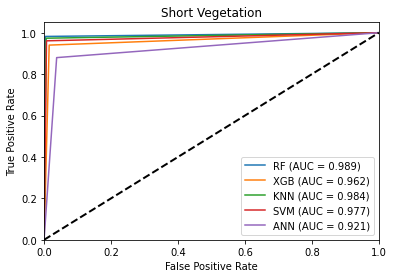

In [ ]:
plt.plot(fpr_rf[1], tpr_rf[1], label='RF (AUC = {:.3f})'.format(roc_auc_rf[1]))
plt.plot(fpr_xgb[1], tpr_xgb[1], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[1]))
plt.plot(fpr_knn[1], tpr_knn[1], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[1]))
plt.plot(fpr_svm[1], tpr_svm[1], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[1]))
plt.plot(fpr_ann[1], tpr_ann[1], label='ANN (AUC = {:.3f})'.format(roc_auc_ann[1]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Short Vegetation")
plt.legend(loc="lower right")
plt.show()

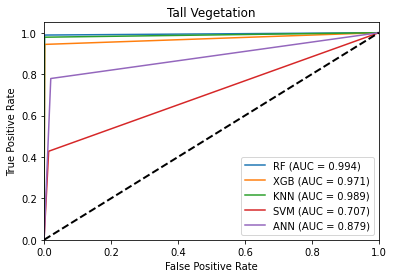

In [ ]:
plt.plot(fpr_rf[2], tpr_rf[2], label='RF (AUC = {:.3f})'.format(roc_auc_rf[2]))
plt.plot(fpr_xgb[2], tpr_xgb[2], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[2]))
plt.plot(fpr_knn[2], tpr_knn[2], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[2]))
plt.plot(fpr_svm[2], tpr_svm[2], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[2]))
plt.plot(fpr_ann[2], tpr_ann[2], label='ANN (AUC = {:.3f})'.format(roc_auc_ann[2]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Tall Vegetation")
plt.legend(loc="lower right")
plt.show()

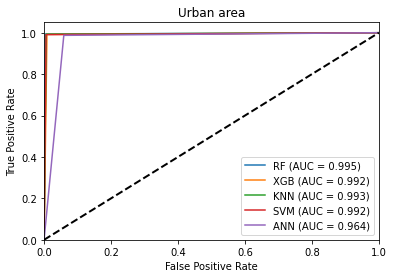

In [ ]:
plt.plot(fpr_rf[3], tpr_rf[3], label='RF (AUC = {:.3f})'.format(roc_auc_rf[3]))
plt.plot(fpr_xgb[3], tpr_xgb[3], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[3]))
plt.plot(fpr_knn[3], tpr_knn[3], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[3]))
plt.plot(fpr_svm[3], tpr_svm[3], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[3]))
plt.plot(fpr_ann[3], tpr_ann[3], label='ANN (AUC = {:.3f})'.format(roc_auc_ann[3]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Urban area")
plt.legend(loc="lower right")
plt.show()

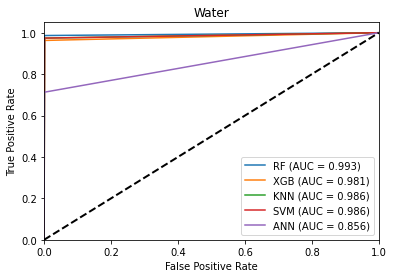

In [ ]:
plt.plot(fpr_rf[4], tpr_rf[4], label='RF (AUC = {:.3f})'.format(roc_auc_rf[4]))
plt.plot(fpr_xgb[4], tpr_xgb[4], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[4]))
plt.plot(fpr_knn[4], tpr_knn[4], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[4]))
plt.plot(fpr_svm[4], tpr_svm[4], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[4]))
plt.plot(fpr_ann[4], tpr_ann[4], label='ANN (AUC = {:.3f})'.format(roc_auc_ann[4]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Water")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
y_test

array([5., 1., 1., ..., 2., 1., 2.], dtype=float32)

In [ ]:
# ax= plt.subplot()

predict_results = model_ANN.predict(X_test)

# predict_results = (predict_results.argmax())
predict_results= predict_results.argmax(axis = 1)
predict_results += 1
cm = metrics.confusion_matrix(y_test, predict_results)

# sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# # labels, title and ticks
# ax.set_xlabel('Predicted labels');
# ax.set_ylabel('True labels');
# ax.set_title('Confusion Matrix for ANN');

313/313 [==============================] - 1s 2ms/step


In [ ]:
cm

array([[2025,  107,    6,   10,    0],
       [ 179, 1661,   42,    6,    0],
       [   6,  174,  885,   88,    0],
       [   6,   24,   13, 3877,    7],
       [   0,    0,    0,  254,  630]])

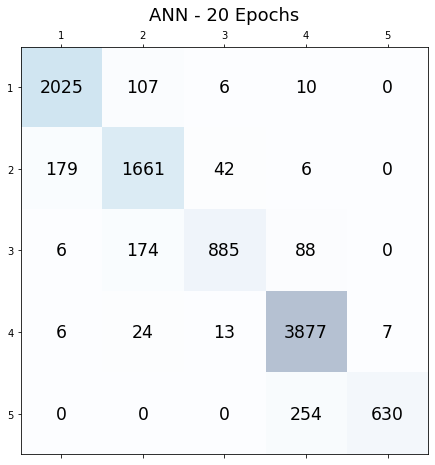

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')


classes = '12345'
plt.xticks(range(5), classes[:5])
plt.yticks(range(5), classes[:5])
# set the locations of the xticks to be on the integers
plt.title('ANN - 20 Epochs', fontsize=18)
plt.show()

In [ ]:
np.unique(predict_results)

array([1, 2, 3, 4, 5])

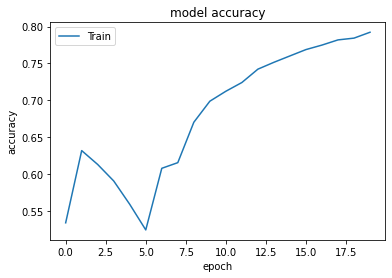

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

In [ ]:
model_ANN2 = Sequential()
model_ANN2.add(InputLayer(input_shape=(2048)))
model_ANN2.add(Dropout(0.2))
model_ANN2.add(Dense(128, activation='relu'))
model_ANN2.add(Dense(64, activation='relu'))
model_ANN2.add(Dropout(0.2))
model_ANN2.add(Dense(32, activation='relu'))
model_ANN2.add(Dense(5, activation="softmax"))
model_ANN2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 5)                 165       
                                                                 
Total params: 272,773
Trainable params: 272,773
Non-tr

In [ ]:
model_ANN2.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history2 = model_ANN2.fit(X_train, y_train_ann, epochs=50)

Epoch 1/50
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6042 - accuracy: 0.7483
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4793 - accuracy: 0.8030
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4455 - accuracy: 0.8163
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4332 - accuracy: 0.8180
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4171 - accuracy: 0.8262
Epoch 6/50
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4050 - accuracy: 0.8296
Epoch 7/50
1250/1250 [==============================] - 8s 7ms/step - loss: 0.3985 - accuracy: 0.8328
Epoch 8/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3907 - accuracy: 0.8345
Epoch 9/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3875 - accuracy: 0.8367
Epoch 10/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.382

In [ ]:
prediction_ANN2 = model_ANN2.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [ ]:
loss, accuracy =  model_ANN2.evaluate(X_test, y_test_act, verbose=2)
print("Accuracy   : {:5.2f}".format(accuracy))

313/313 - 1s - loss: 0.2979 - accuracy: 0.8680 - 670ms/epoch - 2ms/step
Accuracy   :  0.87


In [ ]:
prediction_ann2 = np.array(-1)
for i in prediction_ANN2:
  val = np.where(i == i.max(), 1, 0).tolist()
  prediction_ann2 = np.append(prediction_ann2, val)

prediction_ann2 = prediction_ann2[1:].reshape(10000, 5)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_ann2 = dict()
tpr_ann2 = dict()
roc_auc_ann2 = dict()
for i in range(5):
    fpr_ann2[i], tpr_ann2[i], _ = metrics.roc_curve(y_test_act[:, i], prediction_ann2[:, i])
    roc_auc_ann2[i] = metrics.auc(fpr_ann2[i], tpr_ann2[i])

# Compute micro-average ROC curve and ROC area
fpr_ann2["micro"], tpr_ann2["micro"], _ = metrics.roc_curve(y_test_act.ravel(), prediction_ann2.ravel())
roc_auc_ann2["micro"] = metrics.auc(fpr_ann2["micro"], tpr_ann2["micro"])

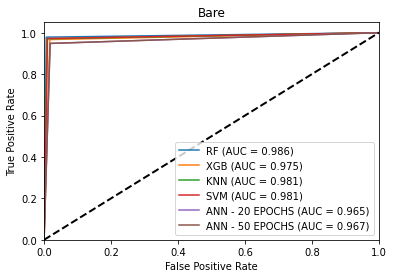

In [ ]:
plt.plot(fpr_rf[0], tpr_rf[0], label='RF (AUC = {:.3f})'.format(roc_auc_rf[0]))
plt.plot(fpr_xgb[0], tpr_xgb[0], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[0]))
plt.plot(fpr_knn[0], tpr_knn[0], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[0]))
plt.plot(fpr_svm[0], tpr_svm[0], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[0]))
plt.plot(fpr_ann[0], tpr_ann[0], label='ANN - 20 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann[0]))
plt.plot(fpr_ann[0], tpr_ann[0], label='ANN - 50 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann2[0]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Bare")
plt.legend(loc="lower right")
plt.show()

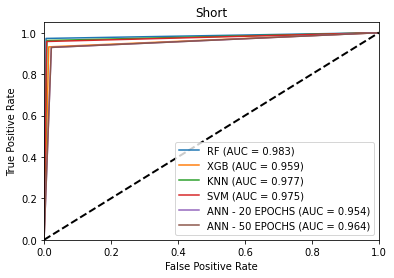

In [ ]:
plt.plot(fpr_rf[1], tpr_rf[1], label='RF (AUC = {:.3f})'.format(roc_auc_rf[1]))
plt.plot(fpr_xgb[1], tpr_xgb[1], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[1]))
plt.plot(fpr_knn[1], tpr_knn[1], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[1]))
plt.plot(fpr_svm[1], tpr_svm[1], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[1]))
plt.plot(fpr_ann[1], tpr_ann[1], label='ANN - 20 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann[1]))
plt.plot(fpr_ann[1], tpr_ann[1], label='ANN - 50 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann2[1]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Short")
plt.legend(loc="lower right")
plt.show()

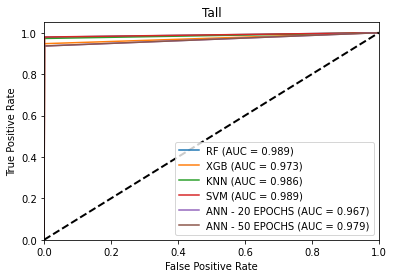

In [ ]:
plt.plot(fpr_rf[2], tpr_rf[2], label='RF (AUC = {:.3f})'.format(roc_auc_rf[2]))
plt.plot(fpr_xgb[2], tpr_xgb[2], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[2]))
plt.plot(fpr_knn[2], tpr_knn[2], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[2]))
plt.plot(fpr_svm[2], tpr_svm[2], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[2]))
plt.plot(fpr_ann[2], tpr_ann[2], label='ANN - 20 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann[2]))
plt.plot(fpr_ann[2], tpr_ann[2], label='ANN - 50 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann2[2]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Tall")
plt.legend(loc="lower right")
plt.show()

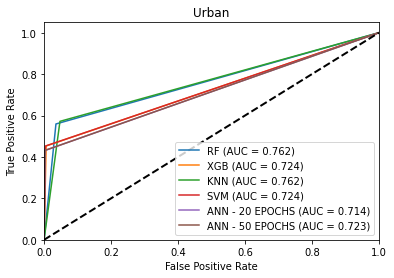

In [ ]:
plt.plot(fpr_rf[3], tpr_rf[3], label='RF (AUC = {:.3f})'.format(roc_auc_rf[3]))
plt.plot(fpr_xgb[3], tpr_xgb[3], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[3]))
plt.plot(fpr_knn[3], tpr_knn[3], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[3]))
plt.plot(fpr_svm[3], tpr_svm[3], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[3]))
plt.plot(fpr_ann[3], tpr_ann[3], label='ANN - 20 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann[3]))
plt.plot(fpr_ann[3], tpr_ann[3], label='ANN - 50 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann2[3]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Urban")
plt.legend(loc="lower right")
plt.show()

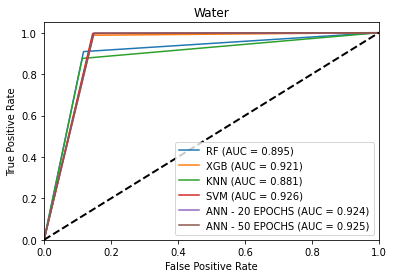

In [ ]:
plt.plot(fpr_rf[4], tpr_rf[4], label='RF (AUC = {:.3f})'.format(roc_auc_rf[4]))
plt.plot(fpr_xgb[4], tpr_xgb[4], label='XGB (AUC = {:.3f})'.format(roc_auc_xgb[4]))
plt.plot(fpr_knn[4], tpr_knn[4], label='KNN (AUC = {:.3f})'.format(roc_auc_knn[4]))
plt.plot(fpr_svm[4], tpr_svm[4], label='SVM (AUC = {:.3f})'.format(roc_auc_svm[4]))
plt.plot(fpr_ann[4], tpr_ann[4], label='ANN - 20 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann[4]))
plt.plot(fpr_ann[4], tpr_ann[4], label='ANN - 50 EPOCHS (AUC = {:.3f})'.format(roc_auc_ann2[4]))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Water")
plt.legend(loc="lower right")
plt.show()

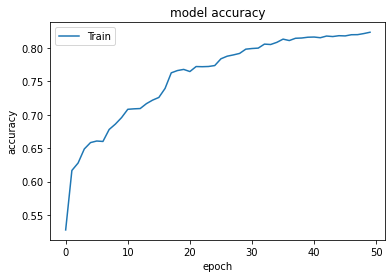

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

In [ ]:
predict_results2 = model_ANN2.predict(X_test)

# predict_results = (predict_results.argmax())
predict_results2 = predict_results2.argmax(axis = 1)
predict_results2 += 1
cm2 = metrics.confusion_matrix(y_test, predict_results2)

# sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# # labels, title and ticks
# ax.set_xlabel('Predicted labels');
# ax.set_ylabel('True labels');
# ax.set_title('Confusion Matrix for ANN');

313/313 [==============================] - 1s 2ms/step


In [ ]:
cm2

array([[1983,  158,    7,    0,    0],
       [ 103, 1738,   47,    0,    0],
       [   6,   45, 1087,   15,    0],
       [   6,   23,   41, 3816,   41],
       [   0,    0,    0,   48,  836]])

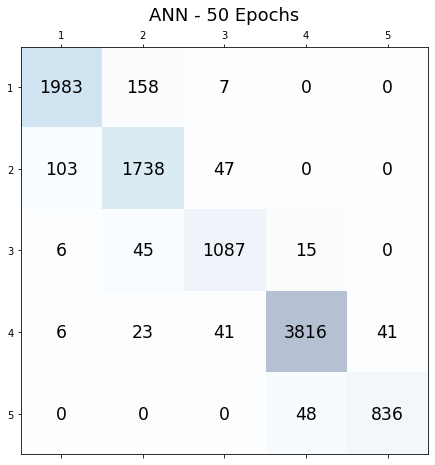

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm2[i, j], va='center', ha='center', size='xx-large')


classes = '12345'
plt.xticks(range(5), classes[:5])
plt.yticks(range(5), classes[:5])
# set the locations of the xticks to be on the integers
plt.title('ANN - 50 Epochs', fontsize=18)
plt.show()

In [ ]:
TrainModel = Sequential()

In [ ]:
Tmodel = ResNet50(include_top=False, weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
Tmodel_config = Tmodel.get_config()

h, w, c = 1, 2048, 1
Tmodel_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

Tmodel_updated = Model.from_config(Tmodel_config)

In [ ]:
from keras.layers.pooling import GlobalAveragePooling2D
def avg_wts(weights):
  average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
  return(average_weights)

Tmodels_updated_config = Tmodel_updated.get_config()
Tmodels_updated_layer_names = [Tmodels_updated_config['layers'][x]['name'] for x in range(len(Tmodels_updated_config['layers']))]

first_conv_name = Tmodels_updated_layer_names[2]
for layer in Tmodel.layers:
    if layer.name in Tmodels_updated_layer_names:

      if layer.get_weights() != []:
        target_layer = Tmodel_updated.get_layer(layer.name)

        if layer.name in first_conv_name:
          weights = layer.get_weights()[0]
          biases  = layer.get_weights()[1]

          weights_single_channel = avg_wts(weights)

          target_layer.set_weights([weights_single_channel, biases])
          target_layer.trainable = False

        else:
          target_layer.set_weights(layer.get_weights())
          target_layer.trainable = False

TrainModel.add(Tmodel_updated)
TrainModel.add(GlobalAveragePooling2D())
TrainModel.add(Dense(5, activation='softmax'))

TrainModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 64, 2048)       23581440  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,591,685
Trainable params: 10,245
Non-trainable params: 23,581,440
_________________________________________________________________


In [ ]:
dataset = np.array(0)

In [ ]:
for i in range(50000):
	pix_value = fused_feature[i]
	pix_value = pix_value.reshape(1, 2048, 1)
	pix_value = np.expand_dims(pix_value, axis=0)
	pred = TrainModel.predict(pix_value)
	print(f"Done with pixel - {i+1}")
	dataset = np.append(dataset, pred)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 146ms/step
Done with pixel - 47501
1/1 [==============================] - 0s 147ms/step
Done with pixel - 47502
1/1 [==============================] - 0s 156ms/step
Done with pixel - 47503
1/1 [==============================] - 0s 160ms/step
Done with pixel - 47504
1/1 [==============================] - 0s 152ms/step
Done with pixel - 47505
1/1 [==============================] - 0s 156ms/step
Done with pixel - 47506
1/1 [==============================] - 0s 148ms/step
Done with pixel - 47507
1/1 [==============================] - 0s 167ms/step
Done with pixel - 47508
1/1 [==============================] - 0s 159ms/step
Done with pixel - 47509
1/1 [==============================] - 0s 147ms/step
Done with pixel - 47510
1/1 [==============================] - 0s 152ms/step
Done with pixel - 47511
1/1 [==============================] - 0s 161ms/step
Done with pixel - 47512
1/1 [====================

In [ ]:
dataset.shape

(250001,)

In [ ]:
dataset = dataset[1:].reshape(5, 50000)

In [ ]:
np.savetxt("drive/MyDrive/Farmland/feature_space_dataset.txt", dataset, fmt='%1.30f')

In [ ]:
feature_space = np.loadtxt("drive/MyDrive/Farmland/feature_space_dataset.txt", dtype=np.float32)

In [ ]:
feature_space

array([[0.00651705, 0.0694508 , 0.15864292, ..., 0.1741351 , 0.62489307,
        0.11043859],
       [0.01242126, 0.10567234, 0.1809819 , ..., 0.18504682, 0.62052757,
        0.13615182],
       [0.04745179, 0.1464478 , 0.38116315, ..., 0.19509257, 0.61006576,
        0.14624763],
       [0.03760748, 0.1499657 , 0.34312892, ..., 0.23538896, 0.49982345,
        0.13612211],
       [0.06793928, 0.12566304, 0.6105764 , ..., 0.57659036, 0.1605529 ,
        0.06734749]], dtype=float32)